In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm
import glob
import os
import csv
from PIL import Image
import matplotlib.animation as animation

##custom
import utils
import myplotcreator as myplot
import gifcreator

In [2]:
def reinforcement_function(plant_ID, psi, profits, plant_ownership_dict, firm_portfolios):
    #recovering the plant ownership
    plant_owner = plant_ownership_dict[plant_ID]
    #recovering all the plants under the same owner
    firm_plant_list = firm_portfolios[plant_owner]
    n = len(firm_plant_list)
    #computing the firm profits
    firm_profit = 0
    for plant in firm_plant_list:
        firm_profit = firm_profit + profits[plant]
    #computing reinforcement for the plant
    reinforcement = psi*profits[plant_ID] + (1-psi)*(firm_profit)/n
    return reinforcement

In [3]:
def compute_firm_profits(firms, firm_portfolios, plant_profits):
    firm_profits = [0.0]*len(firms)
    for firm in firms:
        for plant in firm_portfolios[firm]:
            firm_profits[firm] = firm_profits[firm] + plant_profits[plant]
    return firm_profits

In [4]:
def DemandBuilder(t, plants_df, demand_type = 'constant', total_capacity_fraction = None):

        if demand_type == 'constant':
            total_capacity = plants_df['capacity'].sum()
            if total_capacity_fraction == None:
                 demand = total_capacity*0.5
            else:
                 demand = total_capacity*total_capacity_fraction

        if demand_type == 'sinusoidal':
            total_capacity = plants_df['capacity'].sum()
            period = 200
            demand = 0.5*total_capacity + 1/3*total_capacity*np.sin(2*np.pi/period * t)

        if demand_type == '2periods':
            total_capacity = plants_df['capacity'].sum()
            long_period = 365*4
            short_period = 4
            demand = 0.5*total_capacity + 1/3*total_capacity*np.sin(2*np.pi/long_period * t) +  1/6*total_capacity*np.cos(2*np.pi/short_period * t)
        
        if demand_type == 'noisy-constant':
            total_capacity = plants_df['capacity'].sum()
            gaussian_noise = random.gauss(0, 1)
            demand = total_capacity*0.5 + 1/10*total_capacity*gaussian_noise
              
        return demand

In [5]:
class Model():
    def __init__(self, N, M, J, price_increment, ER_params, seed, costs_management = 'both_costs', timestep_in_days = float(1), run_type = 'single'):
        #Structure
        self.N = N
        self.M = M
        self.J = J
        self.price_increment = price_increment

        #Roth&Erev parameters
        self.epsilon = ER_params[0]
        self.r = ER_params[1]
        self.psi = ER_params[2]
        self.s1 = ER_params[3]

        #Time
        self.t = 0 

        self.costs_management = costs_management
        self.seed = seed
        self.run_type = run_type
        self.timestep_in_days = timestep_in_days

    def DatasetCreator(self, path, distributions):
        #Preparing file where to store data
        filepath = path + 'Norm_LogNormDataset.csv'
        f = open(filepath, 'w')
        f.write('plantID,capacity,fixed_cost,variable_cost\n')

        j=0
        while j < 50: # self.N: #loop over plants
            keep_trying = True
            while keep_trying != False:
            #sampling a capacity in the distribution of capacities
                sampled_capacity = np.random.normal(distributions['capacity']['mean'], distributions['capacity']['std_dev'])
                sampled_fixed_cost = np.random.lognormal(distributions['fixed_cost']['mu'], distributions['fixed_cost']['sigma'])
                sampled_variable_cost = np.random.lognormal(distributions['variable_cost']['mu'], distributions['variable_cost']['sigma'])
                if sampled_capacity > 10 and sampled_fixed_cost <= distributions['fixed_cost']['max'] and sampled_variable_cost <= distributions['variable_cost']['max']:
                    keep_trying = False
            #saving 
            line = "%i,%i,%.2f,%.2f\n"%(j, sampled_capacity, sampled_fixed_cost, sampled_variable_cost)
            f.write(line)
            j += 1

        f.close()
        print(f'Dataset created. Location: {filepath}')

    def FirmPortfoliosCreation(self, database_path, possession_probs):
        np.random.seed(self.seed)
        df = pd.read_csv(database_path)
        #initialization
        plantIDs = df['plantID'].tolist()
        updated_plantIDs = plantIDs.copy()
        firm_portfolios = {firm_ID: [] for firm_ID in range(self.M)}
        plant_ownership_dict_prov= {}
        plant_ownership_dict = {}
        #assigning first plant
        for firm in range(self.M):
            #selecting plant
            selected_plant = np.random.choice(updated_plantIDs)
            #inserting plant in firm's portfolio
            firm_portfolios[firm].append(selected_plant)
            #updating list of ownerless plants
            updated_plantIDs.remove(selected_plant)
        #assigning all remaning plants
        remaining_plants = len(updated_plantIDs)
        while remaining_plants > 0:
            for firm in range(self.M):
                if updated_plantIDs: #checking if the list is not empty (removing this condition brings up an error)
                    p = np.random.uniform(0,1)
                    if p < possession_probs[firm]:
                        selected_plant = np.random.choice(updated_plantIDs)
                        firm_portfolios[firm].append(selected_plant)
                        updated_plantIDs.remove(selected_plant)
                        remaining_plants = len(updated_plantIDs)
        #making a provisional dictionary 
        for firm, portfolio in firm_portfolios.items():
            for plant in portfolio:
                plant_ownership_dict_prov[plant] = firm
        #create tha final dictionary by sorting the previous one by plant ID
        plant_ownership_dict = {key: plant_ownership_dict_prov[key] for key in sorted(plant_ownership_dict_prov)}
        print("All plants were assigned to firms. No more plants left.")
        return firm_portfolios, plant_ownership_dict
        
    def run(self, database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type='constant', total_capacity_fraction = None, output_path = './Simulation_Results/', run_ID = None):

        np.random.seed(self.seed)
        plants_info_df = pd.read_csv(database_path)
        #initializing stuff
        plant_IDs = plants_info_df['plantID'].tolist()
        plant_capacities = plants_info_df['capacity'].tolist()
#        plant_capacities_dict = utils.load_from_plant_csv(database_path, 'capacity')
        plant_capacities_arr = plants_info_df['capacity'].to_numpy()
#        plant_fixed_costs_dict = utils.load_from_plant_csv(database_path, 'fixed_cost')
#            plant_variable_costs_dict = utils.load_from_plant_csv(database_path, 'variable_cost')
        q = np.zeros((self.N,self.J))
        p = np.zeros((self.N,self.J))
        normalization = np.zeros(self.N)
        k = np.zeros(self.N, dtype=int)
        R = np.zeros(self.N)
        profits = np.zeros(self.N)
        marginal_prices_through_time = []
        marginal_prices_through_time.append(0.0)

        #initializing action space
        actions_space = np.tile(np.arange(self.J), (self.N, 1))

        #initializing propensities and probabilities
        for i in range(self.N): #i are plants
            for j in range(self.J): #j are bids
                q[i,j] = self.s1

        simulation_data_dict = utils.initialize_metrics(plants = range(self.N), firms = range(self.M), t_max = t_max, p = p, k=k)
        #let's run the simulation
        self.t = 0        
        while self.t < t_max:
            #update time
            self.t += 1
            #print(f't={self.t}')

            #restrict action space by computing costs first
            #plant_fixed_costs_arr = plants_info_df['fixed_cost'].to_numpy()
            plant_fixed_costs_arr = utils.convert_fixed_cost(plants_info_df['fixed_cost'].to_numpy(dtype=np.float64), self.timestep_in_days)
            if self.costs_management != 'fixed_costs_only':
                plant_variable_costs_per_mwh_arr = plants_info_df['variable_cost'].to_numpy(dtype=np.float64)
            plant_activation_costs = np.zeros(self.N)
            plant_activation_costs_per_mwh = np.zeros(self.N)
            if self.costs_management == 'fixed_costs_only':
                plant_activation_costs = plant_fixed_costs_arr
            elif self.costs_management == 'variable_costs_only':
                plant_activation_costs = plant_variable_costs_per_mwh_arr*plant_capacities_arr
            else:
                plant_variable_costs_arr = plant_variable_costs_per_mwh_arr*plant_capacities_arr
                plant_activation_costs = plant_variable_costs_arr + plant_fixed_costs_arr
            
            #draw action (price)
            k = np.zeros(self.N, dtype=int)
            plant_activation_costs_per_mwh = plant_activation_costs/plant_capacities_arr
            for plant in plant_IDs:
                if plant_activation_costs_per_mwh[plant] > (self.J-1)*self.price_increment:
                    raise RuntimeError(f'Plant {plant} could not bid hoping for a profit. Simulation interrupted.')
            #reducing action space
            forbidden_actions = {}
            for plant in plant_IDs:
                forbidden_actions[plant] = []
                for j in range(self.J):
                    if j*self.price_increment < plant_activation_costs_per_mwh[plant]:
                        forbidden_actions[plant].append(j)
            #initializing probabilities
            for i in range(self.N):
                highest_forbbiden_action = forbidden_actions[i][-1]
                normalization[i] = np.sum(q[i, highest_forbbiden_action+1:])
            for i in range(self.N):
                accessible_actions = [action for action in list(range(self.J)) if action not in forbidden_actions[i]]
                for j in accessible_actions:
                    p[i,j] = q[i,j]/normalization[i]           

            for plant in plant_IDs:
                k[plant] = np.random.choice(actions_space[plant], p = p[plant])
            bids = (k*self.price_increment).tolist()
            plant_activation_costs_per_mwh_list = plant_activation_costs_per_mwh.tolist()
    
            #supply curve
            supply_df = pd.DataFrame({
                'plant_ID': plant_IDs,
                'capacity': plant_capacities,
                'plant_cost': plant_activation_costs_per_mwh_list,
            })
            if self.costs_management == 'fixed_costs_only':
                supply_df['fixed_cost'] = plant_fixed_costs_arr
            elif self.costs_management == 'variable_costs_only':
                supply_df['variable_cost'] = plant_variable_costs_per_mwh_arr
            else:
                supply_df['fixed_cost'] = plant_fixed_costs_arr
                supply_df['variable_cost'] = plant_variable_costs_per_mwh_arr
            supply_df['bid'] = bids
            sorted_by_bid_supply_df = supply_df.sort_values(by='bid')

            #demand curve
            demand = DemandBuilder(self.t, plants_info_df, demand_type, total_capacity_fraction)

            #solving the market
            dispatched_capacity = 0
            marginal_price = 0
            dispatch_schedule = []
            marginal_plants = []

            for index, row in sorted_by_bid_supply_df.iterrows():
                if dispatched_capacity >= demand:
                    break
                plant_ID = row['plant_ID']
                capacity = row['capacity']
                bid_price = row['bid']
                #dispatching the plant
                if dispatched_capacity + capacity < demand: #demand is not met by the selected plant
                    remaining_plants_df = sorted_by_bid_supply_df[sorted_by_bid_supply_df.index > index]
                    prov_dispatched_capacity = dispatched_capacity + capacity
                    marginal_price = bid_price
                    marginal_plants.append((int(plant_ID), capacity, bid_price))                      
                    for remaining_index, remaining_row in remaining_plants_df.iterrows(): #demand could be met by considering other plants bidding at the same price level
                        next_plant_bid_price = remaining_row['bid']
                        if next_plant_bid_price == bid_price:
                            next_plant_ID = remaining_row['plant_ID']
                            next_plant_capacity = remaining_row['capacity']
                            marginal_plants.append((int(next_plant_ID), next_plant_capacity, bid_price))
                            prov_dispatched_capacity += next_plant_capacity
                        else:
                            break
                    if prov_dispatched_capacity < demand:
                        dispatch_schedule.append((int(plant_ID), capacity, bid_price))
                        dispatched_capacity += capacity
                        marginal_plants = []
                    else:
                        break
                else:
                    remaining_demand = demand - dispatched_capacity
                    if marginal_plants == []:
                        marginal_price = bid_price
                        if remaining_demand >= 0:
                            marginal_plants.append((int(plant_ID), capacity, bid_price))
                    else:
                        if bid_price == marginal_price:
                            if remaining_demand >= 0:
                                marginal_plants.append((int(plant_ID), capacity, bid_price))
                        else: 
                            break

            if dispatched_capacity < demand and marginal_plants: # marginal plants exist and demand is not met
                remaining_demand = demand - dispatched_capacity
                total_marginal_capacity = sum(plant[1] for plant in marginal_plants)
                for plant_ID, capacity, bid_price in marginal_plants:
                    proportional_dispatch = (capacity/total_marginal_capacity) * remaining_demand
                    dispatch_schedule.append((int(plant_ID), min(capacity, proportional_dispatch), bid_price))
                    dispatched_capacity += min(capacity, proportional_dispatch)
            supply_df['dispatched'] = False
            supply_df['selling_price'] = 0
            supply_df['supplied_capacity'] = 0.
            supply_df['profit'] = 0.
            for plant_ID, capacity, _ in dispatch_schedule:
                supply_df.loc[supply_df['plant_ID'] == plant_ID, 'dispatched'] = True
                supply_df.loc[supply_df['plant_ID'] == plant_ID, 'supplied_capacity'] = capacity
                supply_df.loc[supply_df['plant_ID'] == plant_ID, 'selling_price'] = marginal_price
                supply_df.loc[supply_df['plant_ID'] == plant_ID, 'profit'] = ((supply_df['selling_price'] - supply_df['plant_cost'])*supply_df['supplied_capacity']).round(2)

            marginal_prices_through_time.append(marginal_price)
            
            #computing profits (if negative, 0 is displayed)
            sorted_by_plantID_supply_df = supply_df.sort_values(by='plant_ID')
            profits = sorted_by_plantID_supply_df['profit'].tolist()

            #recording simulation data
            firm_profits = compute_firm_profits(firms = range(self.M), firm_portfolios = firm_portfolios_dict, plant_profits = profits)
            simulation_data_dict = utils.update_metrics(plants = range(self.N), firms = range(self.M), t = self.t, p = p, k=k, bids=bids, plant_profits=profits, firm_profits=firm_profits, metrics = simulation_data_dict)

            #compute reinforcement
            for plant in range(self.N):
                R[plant] = reinforcement_function(plant, self.psi, profits, plant_ownership_dict, firm_portfolios_dict)
            #update propensities
            for i in range(self.N):
                for j in range(self.J):
                    if j == k[i]:
                        q[i,j] = (1-self.r)*q[i,j]+R[i]*(1-self.epsilon)
                    else:
                        q[i,j] = (1-self.r)*q[i,j]+q[i,j]*self.epsilon/(self.J-1)
        
        #creating a subfolder structure if run_type is set to multiple
        if self.run_type == 'multiple':
            output_path = output_path + fr'varying_params/run_with_params_eps_{self.epsilon}_r_{self.r}_psi_{self.psi}_s1_{self.s1}_{self.costs_management}/run_{run_ID}/'
        else:
            output_path = output_path + fr'single_run_with_eps_{self.epsilon}_r_{self.r}_psi_{self.psi}_s1_{self.s1}_{self.costs_management}/'
        #checking if output_path exists, if not creating it
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        csv_filenames = {}
        #saving simulation data
        prob_data = simulation_data_dict['prob_data']
        csv_filenames = utils.save_metrics_to_csv(metrics = simulation_data_dict, t_max = t_max, output_path = output_path, csv_filenames=csv_filenames) #be careful, this functiond deletes prob_data
        #saving prices data
        csv_filenames = utils.save_prices_to_csv(marginal_prices_through_time, t_max, output_path, csv_filenames)                
        if self.run_type == 'single':
            print('Results stored here:')
            formatted_csv_filenames = ' - '
            formatted_csv_filenames = formatted_csv_filenames+'\n - '.join([f"{key}: {value}" for key, value in csv_filenames.items()])
            print(formatted_csv_filenames)
        return csv_filenames, prob_data

## Seed

In [6]:
seed = 12
np.random.seed(seed)

## Plant charcteristics with mixed distribution

In [7]:
labels = ['capacity', 'fuel_cost', 'variable_cost', 'fixed_cost']
distribution_types = ['normal', 'normal', 'lognormal', 'lognormal']
means = [122.72, 28.60, 137.96, 16.20]
stds = [162.89, 31.85, 3448.22, 13.52]
#fixed_costs_multiplier = 1
#means = [122.72, 28.60, 137.96, 16.20*fixed_costs_multiplier]
#stds = [162.89, 31.85, 3448.22, 13.52*fixed_costs_multiplier]
mins = [0.05, 0.00, 1.25, 0.22]
perc25s = [8.50, 0.00, 5.18, 9.54] 
perc50s = [77.60, 24.42, 11.30, 12.91]
perc75s = [177.00, 39.71, 30.85, 18.91]
maxs = [1354.30, 670.54, 309272.82, 138.00]


In [8]:
distributions_dict = {}

for i in range(4):
    # i = 0 -> capacity; i=1 -> fuel_cost; i=2 -> variable_cost, i=3 -> fixed_cost
    name = labels[i]
    mean = means[i]
    std = stds[i]
    distribution_type = distribution_types[i]

    if distribution_type == 'normal':
        distributions_dict[name] = {
            'distribution_type': distribution_type,
            'mean': mean,
            'std_dev': std
        }
    elif distribution_type == 'lognormal':
        mu, sigma = utils.fit_lognormal_from_percentiles(p25 = perc25s[i], p50 = perc50s[i], p75 = perc75s[i])
        distributions_dict[name] = {
            'distribution_type': distribution_type,
            'mu': mu,
            'sigma': sigma,
            'max': maxs[i]
        }
    
#print(distributions_dict)

## Model parameters and strcture initialization

In [9]:
N = 50 #total number of plants
M = 10 #total number of firms

price_increment = 10 #discretization of bid space

min_price = 0 
max_price = 1000

J = int((max_price-min_price)/(price_increment)+1) #total number of actions (prices)

epsilon = 0.89
r = 0.07
psi = 0.7
s1 = 700000

ER_params = [epsilon, r, psi, s1]

costs_management = 'both_costs'
run_type = 'single'
timestep_in_days = 1

In [10]:
simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)

### Database creation and ownership dictionaries creation

In [11]:
db_directory_path = './Data/'
#simulation.DatasetCreator(db_directory_path, distributions_dict)

In [12]:
database_path = './Data/Norm_LogNormDataset.csv'

possession_probs = []
for firm in range(M):
    possession_probs.append(np.random.uniform(0,1))

#print(possession_probs)

firm_portfolios_dict, plant_ownership_dict = simulation.FirmPortfoliosCreation(database_path, possession_probs)

entries_dict = {'plants_owned': None, 'total_capacity': 'capacity', 'total_fixed_cost': 'fixed_cost', 'total_variable_cost': 'variable_cost'}
corresponding_data_columns = ['']
structured_firm_dict = {}
plants_info_df = pd.read_csv(database_path)
for firm in firm_portfolios_dict.keys():
    structured_firm_dict[firm] = {}
    for entry in entries_dict.keys():
        if entry == 'plants_owned':
            structured_firm_dict[firm][entry] = firm_portfolios_dict[firm]
        else: 
            total_quantity = 0
            for plant in firm_portfolios_dict[firm]:
                plant_quantity = plants_info_df.loc[plant, entries_dict[entry]]
                total_quantity += plant_quantity
            structured_firm_dict[firm][entry] = total_quantity 

#print(firm_portfolios_dict)
#print(plant_ownership_dict)
#print(structured_firm_dict)


All plants were assigned to firms. No more plants left.


## Simulations 

In [13]:
t_max = 600
demand_type = 'constant'
output_path = './Simulation_Results/'

In [14]:
csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, total_capacity_fraction=None,output_path = output_path)
plot_saving_directory = fr'./Figures/single_run_with_eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}_t_max_{t_max}/'

...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
Results stored here:
 - chosen_action_data: ./Simulation_Results/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/chosen_action_data.csv
 - bid_data: ./Simulation_Results/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/bid_data.csv
 - plant_profits_data: ./Simulation_Results/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/plant_profits_data.csv
 - firm_profits_data: ./Simulation_Results/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/firm_profits_data.csv
 - price_data: ./Simulation_Results/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/prices.csv


In [15]:
prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
chosen_action_data = utils.load_dict_data_from_csv(csv_filenames['chosen_action_data'], data_to_load='chosen_action_data')
bid_data = utils.load_dict_data_from_csv(csv_filenames['bid_data'], data_to_load='bid_data')
plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')

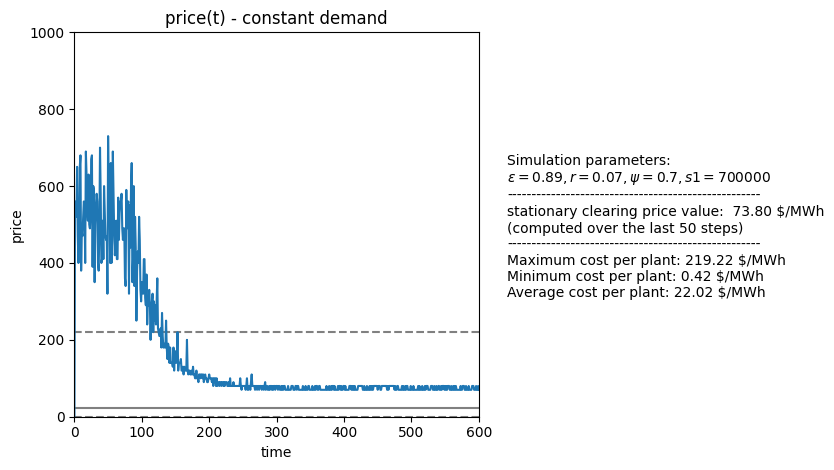

Plot saved here: ./Figures/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs_t_max_600/prices.png


In [16]:
save_path = os.path.join(plot_saving_directory, 'prices.png')
myplot.prices(prices_data_list, demand_type, database_path, t_max, min_price, max_price, ER_params, costs_management, should_save=True, save_path=save_path, should_show=True)

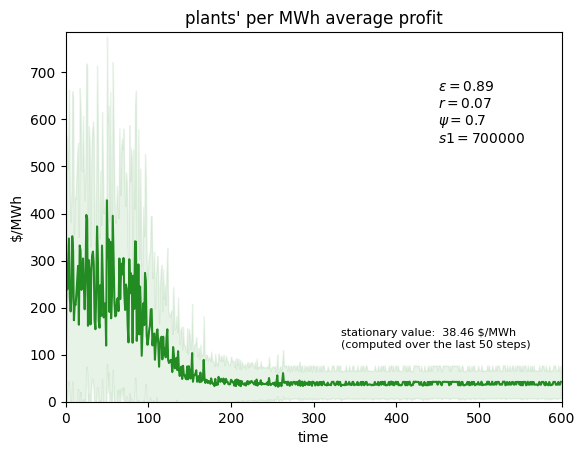

Plot saved here: ./Figures/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs_t_max_600/average_plant_profit.png


In [17]:
save_path = os.path.join(plot_saving_directory, 'average_plant_profit.png')
myplot.average_plant_profits(database_path, plant_profits_data, N, t_max, ER_params, profits_per = 'MWh', should_save=True, save_path=save_path, should_show=True)

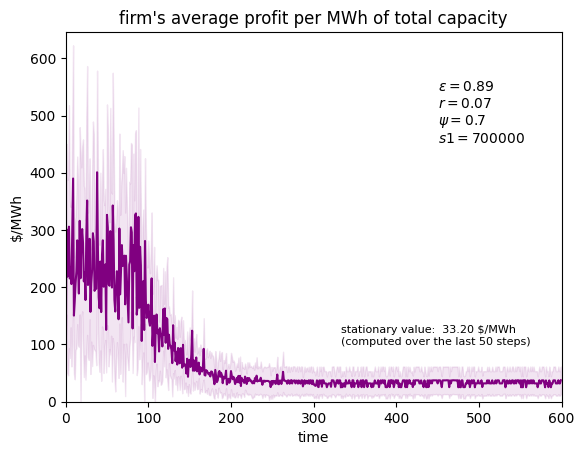

Plot saved here: ./Figures/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs_t_max_600/average_firm_profit.png


In [18]:
save_path = os.path.join(plot_saving_directory, 'average_firm_profit.png')
myplot.average_firm_profits(firm_profits_data, firm_portfolios_dict, structured_firm_dict, profits_per = 'MWh', t_max=t_max, ER_params=ER_params, should_save=True, save_path=save_path, should_show=True)

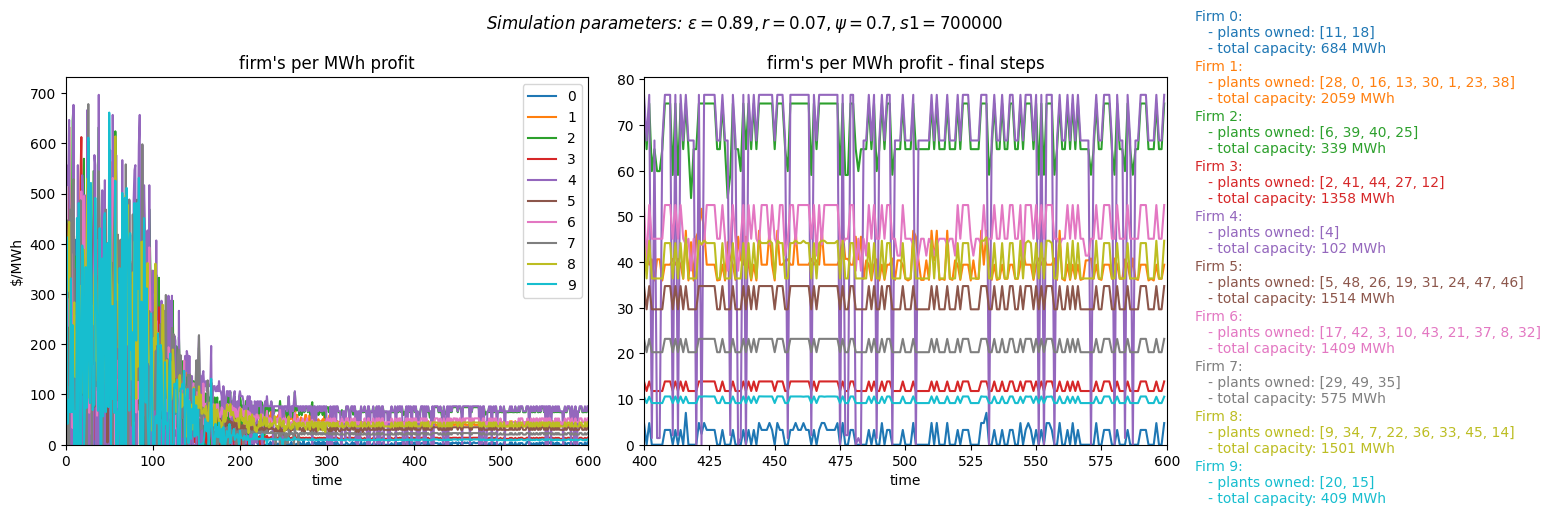

Plot saved here: ./Figures/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs_t_max_600/firm_profit.png


In [19]:
save_path = os.path.join(plot_saving_directory, 'firm_profit.png')
myplot.firm_profits(firm_profits_data, firm_portfolios_dict, structured_firm_dict, profits_per='MWh', t_max = t_max, ER_params=ER_params, should_save=True, save_path=save_path, should_show=True)

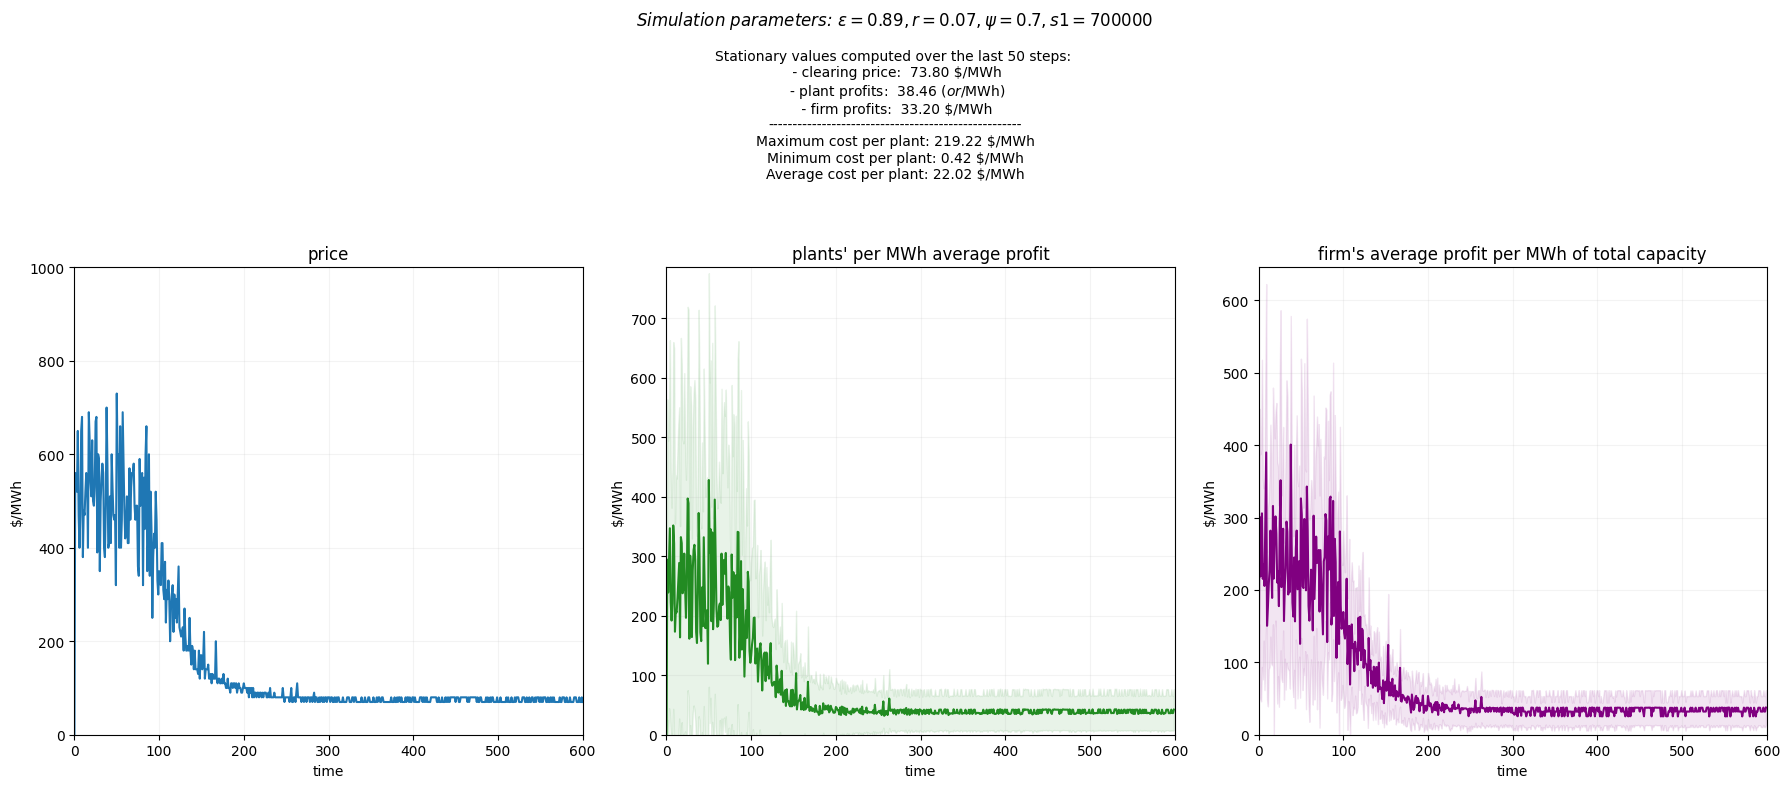

Plot saved here: ./Figures/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs_t_max_600/simulation_overview.png


In [20]:
save_path = os.path.join(plot_saving_directory, 'simulation_overview.png')
myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management, should_save=True, save_path=save_path, should_show=True)

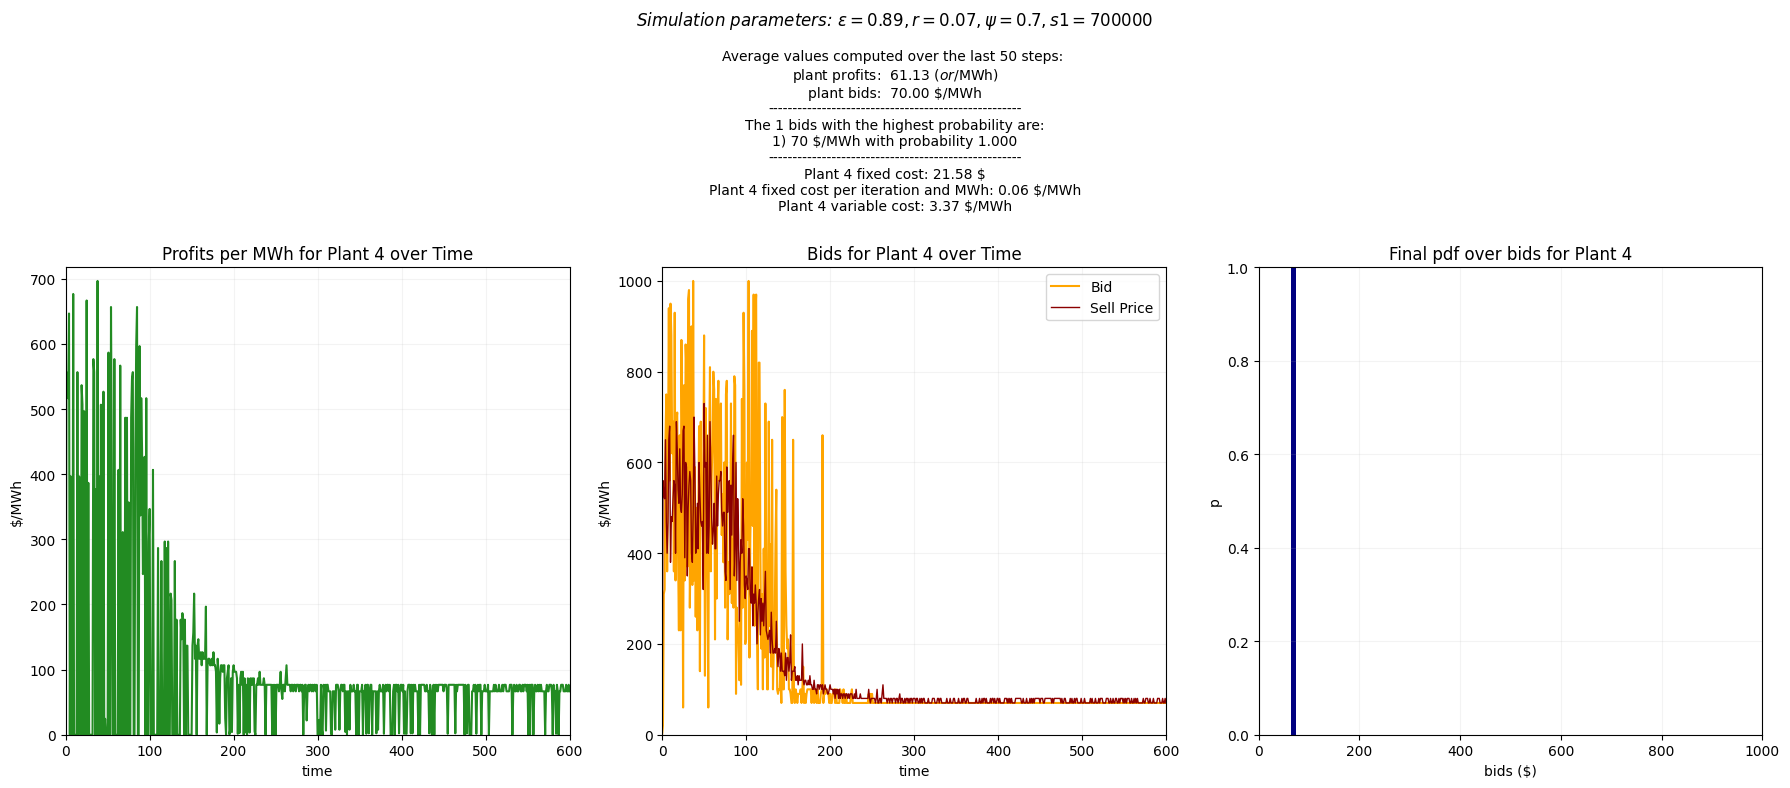

Plot saved here: ./Figures/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs_t_max_600/plant_4_overview.png


In [21]:
plant_ID = 4 #1 and 35
save_path = os.path.join(plot_saving_directory, f'plant_{plant_ID}_overview.png')
myplot.plant_overview(database_path, plant_ID, t_max, plant_profits_data, bid_data, price_increment, prices_data_list, prob_data, ER_params, profits_per = 'MWh', timestep_in_days = timestep_in_days, should_save = True, save_path = save_path, should_show = True)

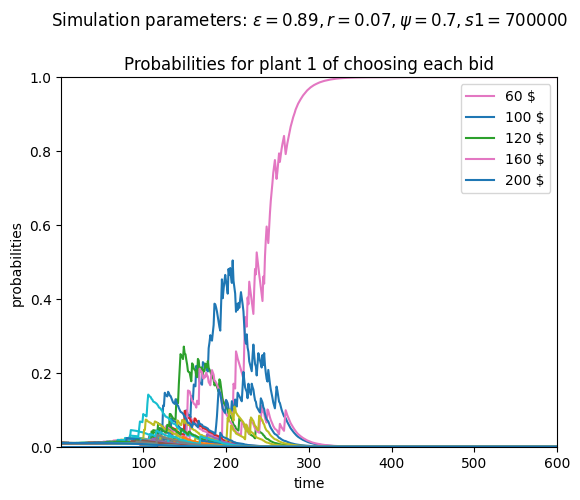

<Figure size 640x480 with 0 Axes>

Plot saved here: ./Figures/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs_t_max_600/bid_probabilities_for_plant_1.png


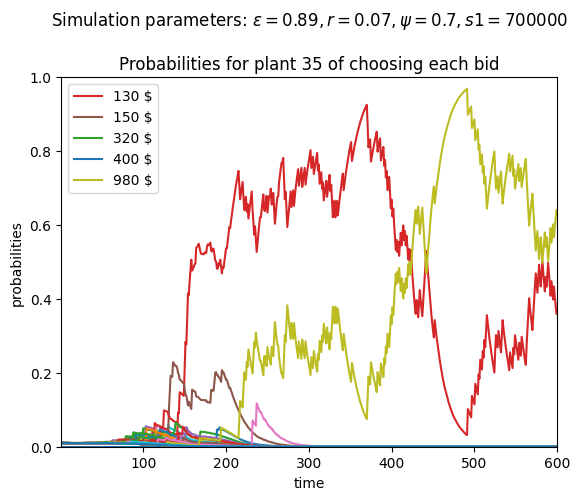

<Figure size 640x480 with 0 Axes>

Plot saved here: ./Figures/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs_t_max_600/bid_probabilities_for_plant_35.png


In [22]:
plant_list = [1,35]

myplot.bid_probabilities_over_time(prob_data, plant_list, price_increment, t_max, J, ER_params, should_save = True, saving_directory = plot_saving_directory, should_show = True, debug = False)

In [ ]:
gifcreator.bid_popularity(bid_data, price_increment, ER_params, J, range(N), t_max, save_path = plot_saving_directory, time_stamp_every=10)

Saved 10 frames.
Saved 20 frames.
Saved 30 frames.
Saved 40 frames.
Saved 50 frames.


MovieWriter ffmpeg unavailable; using Pillow instead.


Saved 60 frames.
I'm done creating the single frames, I will now move to making a gif out of them.
GIF saved as ./Figures/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs_t_max_600/bid_GIF_params_eps_0.89_r_0.07_psi_0.7_s1_700000.gif


In [26]:
plant_ID = 35
fixed_costs = plants_info_df['fixed_cost'].to_numpy()
plant_fixed_cost = fixed_costs[plant_ID]
gifcreator.single_plant_pdf_evolution(database_path, plant_ID, prob_data, min_price, max_price, price_increment, ER_params, t_max, save_path = plot_saving_directory, time_stamp_every=10, costs_management=costs_management)

c:\Users\harry\Desktop\Unito\Tesi\Avanzamento progressi\05_Toy_Model\gifcreator.py:91: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0,maximum_y_value*2)


Saved 10 frames.
Saved 20 frames.
Saved 30 frames.
Saved 40 frames.
Saved 50 frames.


MovieWriter ffmpeg unavailable; using Pillow instead.


Saved 60 frames.
I'm done creating the single frames, I will now move to making a gif out of them.
GIF saved as ./Figures/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs_t_max_600/plant_35_pdf_GIF_params_eps_0.89_r_0.07_psi_0.7_s1_700000.gif


In [25]:
gifcreator.pdf_evo_gif_creator(prob_data, min_price, max_price, price_increment, range(N), ER_params, t_max, save_path=plot_saving_directory, time_stamp_every=10)

Saved 10 frames.
Saved 20 frames.
Saved 30 frames.
Saved 40 frames.
Saved 50 frames.
I'm done creating the single frames, I will now move to making a gif out of them.


MovieWriter ffmpeg unavailable; using Pillow instead.


GIF saved as ./Figures/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs_t_max_600/plant_evo_pdf_GIF_params_eps_0.89_r_0.07_psi_0.7_s1_700000.gif


## Varying demand

In [ ]:
total_capacity_fractions = np.arange(0.05,1.05, 0.05)
csv_filenames_dict = {}
run_counter = 0
for fraction in total_capacity_max_prices:
    run_counter += 1
    print('-'*44)
    print(f'{run_counter} - fraction: {fraction}')
    epsilon = 0.89
    r = 0.07
    psi = 0.7
    s1 = 700000

    ER_params = [epsilon, r, psi, s1]

    costs_management = 'both_costs'
    run_type = 'multiple'
    timestep_in_days = 1

    t_max = 600
    demand_type = 'constant'
    output_path = f'./Simulation_Results/Varying_Constant_Demand/Demand_fraction_{fraction}/'

    simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)
    print(f'Initialized simulation with params: {ER_params}')
    plot_saving_directory = fr'./Figures/Varying_Constant_Demand_with_eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}_t_max_{t_max}/Demand_fraction_{fraction}/'
    csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, total_capacity_fraction=fraction, output_path=output_path, run_ID=0)
    csv_filenames_dict[fraction] = csv_filenames
    print('saving plots...')
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    save_path = os.path.join(plot_saving_directory, 'simulation_overview.png')
    myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management, should_save=True, save_path=save_path, should_show=False)

--------------------------------------------
1 - fraction: 0.05
Initialized simulation with params: [0.89, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
2 - fraction: 0.1
Initialized simulation with params: [0.89, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
3 - fraction: 0.15000000000000002
Initialized simulation with params: [0.89, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
4 - fraction: 0.2
Initialized simulation with params: [0.89, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
5 - fraction: 

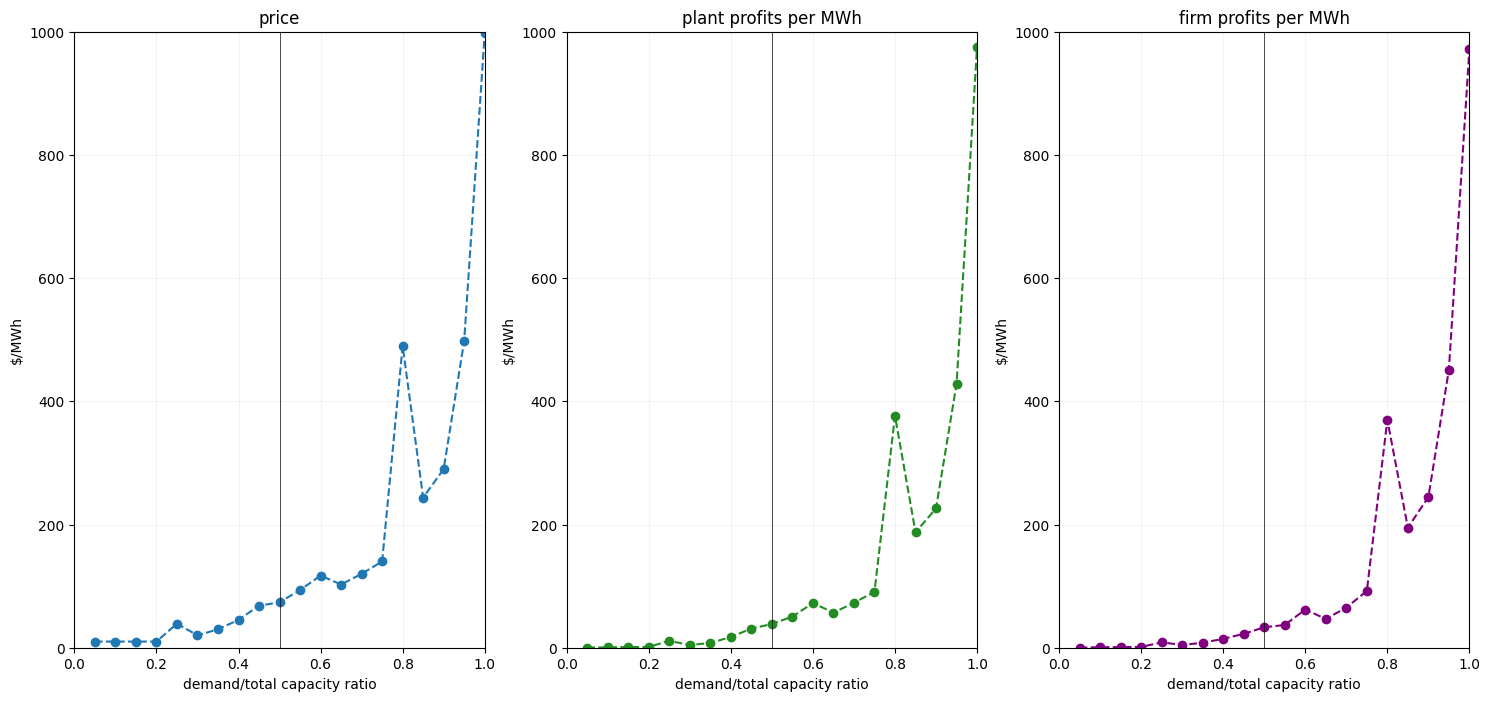

In [ ]:
stationary_values = {}
number_of_plants = N
number_of_firms = M
prices = []
plant_profits = []
firm_profits = []
for fraction in total_capacity_fractions:
    stationary_values[fraction] = {}

    csv_filenames = csv_filenames_dict[fraction]
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    
    stationary_values[fraction]['price'] = utils.get_stationary_value(np.array(prices_data_list))
    
    plants_info_df = pd.read_csv(database_path)
    plant_capacities = plants_info_df['capacity'].to_numpy()
    total_capacity_of_firms = np.zeros(number_of_firms)
    for firm in firm_portfolios_dict.keys():
        total_capacity_of_firms[firm] = structured_firm_dict[firm]['total_capacity']
    avg_plant_profit_through_time = np.zeros(t_max)
    avg_firm_profit_through_time = np.zeros(t_max)
    for t in range(t_max):
        plant_profits_at_time_t = np.zeros(number_of_plants)
        for plant in range(number_of_plants):
            plant_profits_at_time_t[plant] = plant_profits_data[plant][t]/plant_capacities[plant]
        avg_plant_profit_through_time[t] = np.mean(plant_profits_at_time_t)
        firm_profits_at_time_t = np.zeros(number_of_firms)
        for firm in range(number_of_firms):
            firm_profits_at_time_t[firm] = firm_profits_data[firm][t]/total_capacity_of_firms[firm]
        avg_firm_profit_through_time[t] = np.mean(firm_profits_at_time_t)
    stationary_values[fraction]['plant_profits'] = utils.get_stationary_value(avg_plant_profit_through_time)
    stationary_values[fraction]['firm_profits'] = utils.get_stationary_value(avg_firm_profit_through_time)

    prices.append(stationary_values[fraction]['price'])
    plant_profits.append(stationary_values[fraction]['plant_profits'])
    firm_profits.append(stationary_values[fraction]['firm_profits'])
    
#plotting
colors = ['#1f77b4', 'forestgreen', 'purple']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))
### ax1: prices
ax1.plot(total_capacity_fractions, prices, marker='o', linestyle='--', color = colors[0])
ax1.axvline(0.5, color='black', linewidth=.5)
ax1.set_xlim(0, 1)
ax1.set_ylim(min_price, max_price)
ax1.set_xlabel('demand/total capacity ratio')
ax1.set_ylabel('$/MWh')
ax1.set_title(f"price")
ax1.grid(alpha=0.15)
### ax2: profits per plant
ax2.plot(total_capacity_fractions, plant_profits, marker='o', linestyle='--', color = colors[1])
ax2.axvline(0.5, color='black', linewidth=.5)
ax2.set_xlim(0, 1)
ax2.set_ylim(min_price, max_price)
ax2.set_xlabel('demand/total capacity ratio')
ax2.set_ylabel('$/MWh')
ax2.set_title(f"plant profits per MWh")
ax2.grid(alpha=0.15)
### ax2: profits per firm
ax3.plot(total_capacity_fractions, firm_profits, marker='o', linestyle='--', color = colors[2])
ax3.axvline(0.5, color='black', linewidth=.5)
ax3.set_xlim(0, 1)
ax3.set_ylim(min_price, max_price)
ax3.set_xlabel('demand/total capacity ratio')
ax3.set_ylabel('$/MWh')
ax3.set_title(f"firm profits per MWh")
ax3.grid(alpha=0.15)

plt.savefig(f'./Figures/Varying_Constant_Demand_with_eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}_t_max_{t_max}/overview.png')
plt.show()

## Multiple parameters simulations

### Let's start by varying $\varepsilon$

In [15]:
param_to_vary = 'epsilon'
epsilons = np.arange(0.0,1.05, 0.05)
csv_filenames_dict = {}
run_counter = 0
for epsilon in epsilons:
    run_counter += 1
    print('-'*44)
    print(f'{run_counter} - epsilon: {epsilon}')
    #epsilon = 0.89
    r = 0.07
    psi = 0.7
    s1 = 700000

    ER_params = [epsilon, r, psi, s1]

    costs_management = 'both_costs'
    run_type = 'multiple'
    timestep_in_days = 1

    t_max = 600
    demand_type = 'constant'
    output_path = f'./Simulation_Results/'

    simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)
    print(f'Initialized simulation with params: {ER_params}')
    plot_saving_directory = fr'./Figures/Varying_Params/{param_to_vary}/eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}_t_max_{t_max}/'
    csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, total_capacity_fraction=None, output_path=output_path, run_ID=0)
    csv_filenames_dict[epsilon] = csv_filenames
    print('saving plots...')
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    chosen_action_data = utils.load_dict_data_from_csv(csv_filenames['chosen_action_data'], data_to_load='chosen_action_data')
    bid_data = utils.load_dict_data_from_csv(csv_filenames['bid_data'], data_to_load='bid_data')
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    save_path = os.path.join(plot_saving_directory, 'simulation_overview.png')
    myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management, should_save=True, save_path=save_path, should_show=False)
    save_path = os.path.join(plot_saving_directory, 'firm_profit.png')
    myplot.firm_profits(firm_profits_data, firm_portfolios_dict, structured_firm_dict, profits_per='MWh', t_max = t_max, ER_params=ER_params, should_save=True, save_path=save_path, should_show=False)

--------------------------------------------
1 - epsilon: 0.0
Initialized simulation with params: [0.0, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
2 - epsilon: 0.05
Initialized simulation with params: [0.05, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
3 - epsilon: 0.1
Initialized simulation with params: [0.1, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
4 - epsilon: 0.15000000000000002
Initialized simulation with params: [0.15000000000000002, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
5 - e

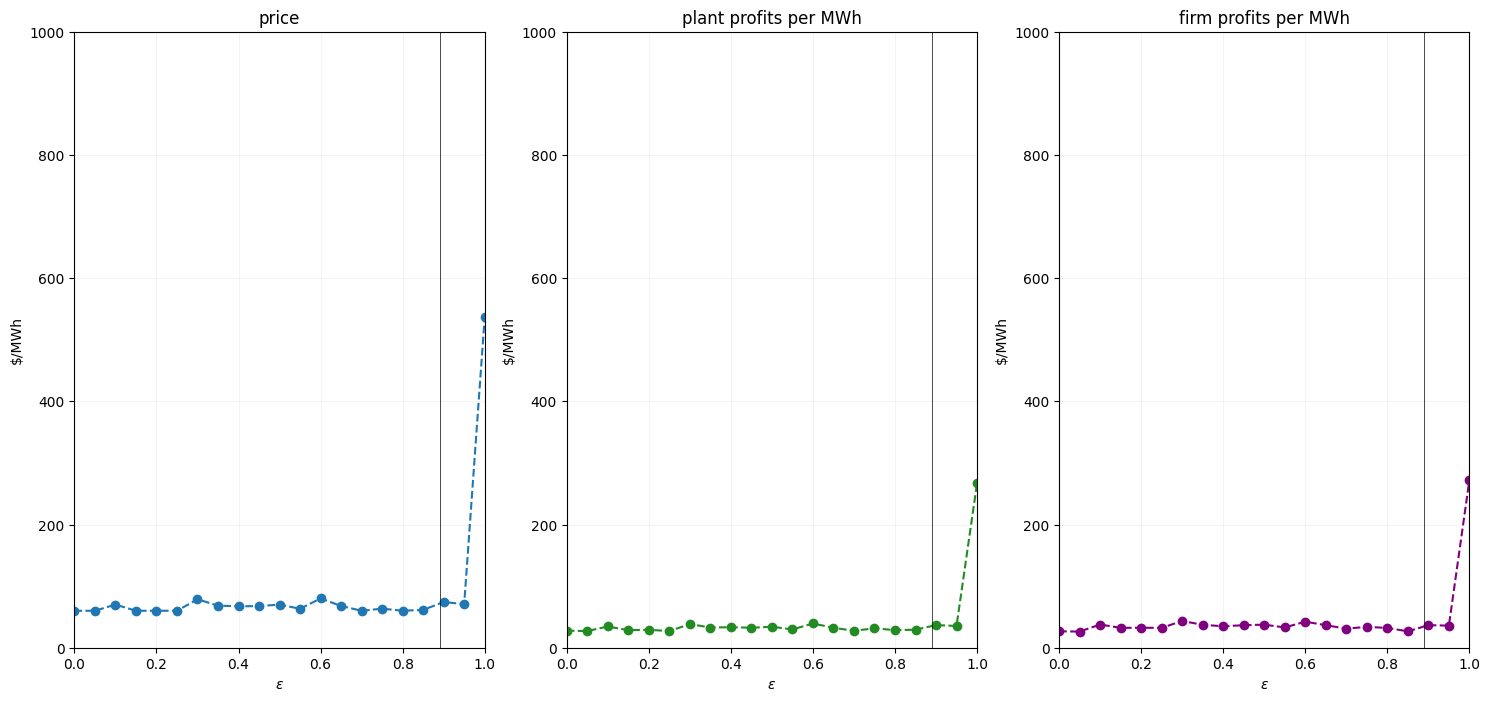

In [16]:
stationary_values = {}
number_of_plants = N
number_of_firms = M
prices = []
plant_profits = []
firm_profits = []
for epsilon in epsilons:
    stationary_values[epsilon] = {}

    csv_filenames = csv_filenames_dict[epsilon]
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    
    stationary_values[epsilon]['price'] = utils.get_stationary_value(np.array(prices_data_list))
    
    plants_info_df = pd.read_csv(database_path)
    plant_capacities = plants_info_df['capacity'].to_numpy()
    total_capacity_of_firms = np.zeros(number_of_firms)
    for firm in firm_portfolios_dict.keys():
        total_capacity_of_firms[firm] = structured_firm_dict[firm]['total_capacity']
    avg_plant_profit_through_time = np.zeros(t_max)
    avg_firm_profit_through_time = np.zeros(t_max)
    for t in range(t_max):
        plant_profits_at_time_t = np.zeros(number_of_plants)
        for plant in range(number_of_plants):
            plant_profits_at_time_t[plant] = plant_profits_data[plant][t]/plant_capacities[plant]
        avg_plant_profit_through_time[t] = np.mean(plant_profits_at_time_t)
        firm_profits_at_time_t = np.zeros(number_of_firms)
        for firm in range(number_of_firms):
            firm_profits_at_time_t[firm] = firm_profits_data[firm][t]/total_capacity_of_firms[firm]
        avg_firm_profit_through_time[t] = np.mean(firm_profits_at_time_t)
    stationary_values[epsilon]['plant_profits'] = utils.get_stationary_value(avg_plant_profit_through_time)
    stationary_values[epsilon]['firm_profits'] = utils.get_stationary_value(avg_firm_profit_through_time)

    prices.append(stationary_values[epsilon]['price'])
    plant_profits.append(stationary_values[epsilon]['plant_profits'])
    firm_profits.append(stationary_values[epsilon]['firm_profits'])
    
#plotting
colors = ['#1f77b4', 'forestgreen', 'purple']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))
### ax1: prices
ax1.plot(epsilons, prices, marker='o', linestyle='--', color = colors[0])
ax1.axvline(0.89, color='black', linewidth=.5)
ax1.set_xlim(0, 1)
ax1.set_ylim(min_price, max_price)
ax1.set_xlabel('$\epsilon$')
ax1.set_ylabel('$/MWh')
ax1.set_title(f"price")
ax1.grid(alpha=0.15)
### ax2: profits per plant
ax2.plot(epsilons, plant_profits, marker='o', linestyle='--', color = colors[1])
ax2.axvline(0.89, color='black', linewidth=.5)
ax2.set_xlim(0, 1)
ax2.set_ylim(min_price, max_price)
ax2.set_xlabel('$\epsilon$')
ax2.set_ylabel('$/MWh')
ax2.set_title(f"plant profits per MWh")
ax2.grid(alpha=0.15)
### ax2: profits per firm
ax3.plot(epsilons, firm_profits, marker='o', linestyle='--', color = colors[2])
ax3.axvline(0.89, color='black', linewidth=.5)
ax3.set_xlim(0, 1)
ax3.set_ylim(min_price, max_price)
ax3.set_xlabel('$\epsilon$')
ax3.set_ylabel('$/MWh')
ax3.set_title(f"firm profits per MWh")
ax3.grid(alpha=0.15)

plt.savefig(f'./Figures/Varying_Params/{param_to_vary}/overview.png')
plt.show()

### Varying $r$

In [17]:
param_to_vary = 'r'
rs = np.arange(0.0,1.05,0.05)
csv_filenames_dict = {}
run_counter = 0
for r in rs:
    run_counter += 1
    print('-'*44)
    print(f'{run_counter} - r: {r}')
    epsilon = 0.89
    #r = 0.07
    psi = 0.7
    s1 = 700000

    ER_params = [epsilon, r, psi, s1]

    costs_management = 'both_costs'
    run_type = 'multiple'
    timestep_in_days = 1

    t_max = 600
    demand_type = 'constant'
    output_path = f'./Simulation_Results/'

    simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)
    print(f'Initialized simulation with params: {ER_params}')
    plot_saving_directory = fr'./Figures/Varying_Params/{param_to_vary}/eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}_t_max_{t_max}/'
    csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, total_capacity_fraction=None, output_path=output_path, run_ID=0)
    csv_filenames_dict[r] = csv_filenames
    print('saving plots...')
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    chosen_action_data = utils.load_dict_data_from_csv(csv_filenames['chosen_action_data'], data_to_load='chosen_action_data')
    bid_data = utils.load_dict_data_from_csv(csv_filenames['bid_data'], data_to_load='bid_data')
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    save_path = os.path.join(plot_saving_directory, 'simulation_overview.png')
    myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management, should_save=True, save_path=save_path, should_show=False)
    save_path = os.path.join(plot_saving_directory, 'firm_profit.png')
    myplot.firm_profits(firm_profits_data, firm_portfolios_dict, structured_firm_dict, profits_per='MWh', t_max = t_max, ER_params=ER_params, should_save=True, save_path=save_path, should_show=False)

--------------------------------------------
1 - r: 0.0
Initialized simulation with params: [0.89, 0.0, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
2 - r: 0.05
Initialized simulation with params: [0.89, 0.05, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
3 - r: 0.1
Initialized simulation with params: [0.89, 0.1, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
4 - r: 0.15000000000000002
Initialized simulation with params: [0.89, 0.15000000000000002, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
5 - r: 0.2
Initialized simula

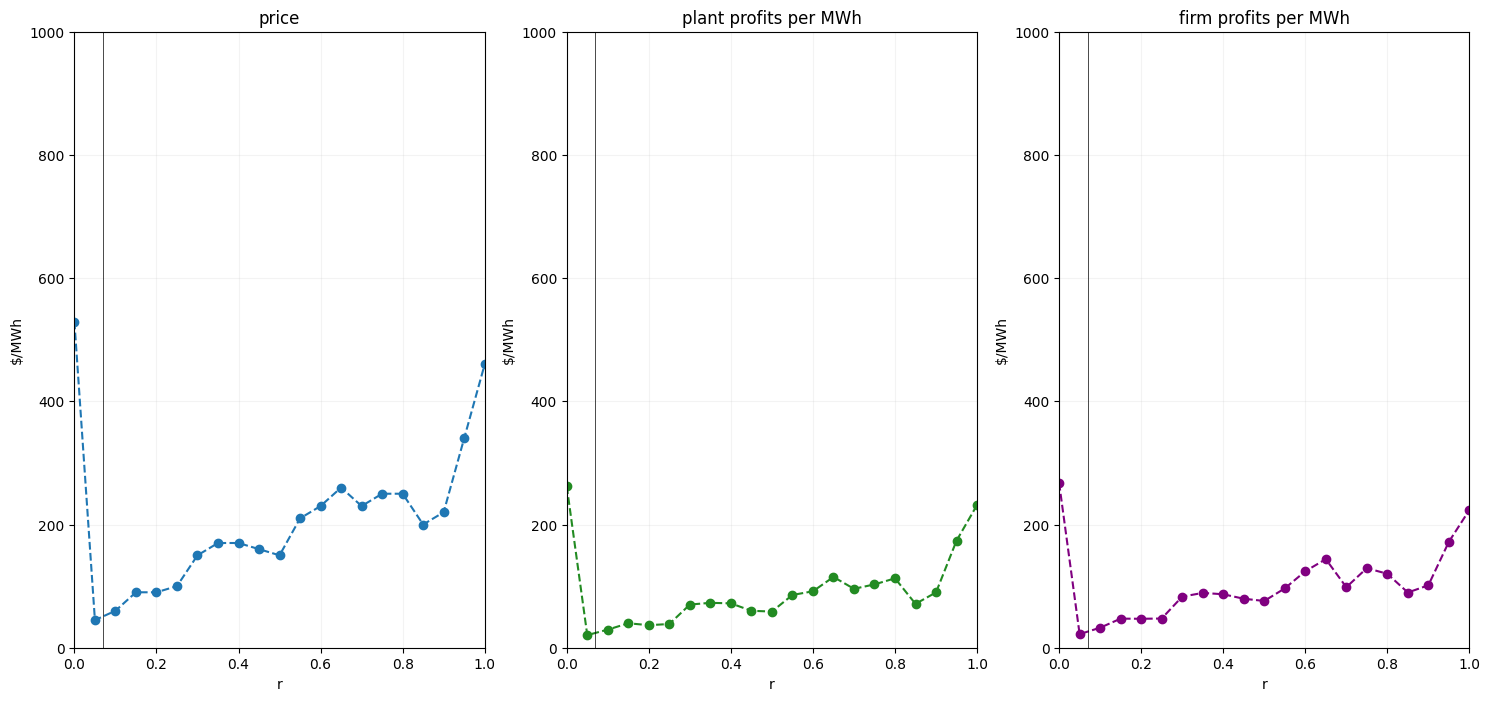

In [18]:
stationary_values = {}
number_of_plants = N
number_of_firms = M
prices = []
plant_profits = []
firm_profits = []
for r in rs:
    stationary_values[r] = {}

    csv_filenames = csv_filenames_dict[r]
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    
    stationary_values[r]['price'] = utils.get_stationary_value(np.array(prices_data_list))
    
    plants_info_df = pd.read_csv(database_path)
    plant_capacities = plants_info_df['capacity'].to_numpy()
    total_capacity_of_firms = np.zeros(number_of_firms)
    for firm in firm_portfolios_dict.keys():
        total_capacity_of_firms[firm] = structured_firm_dict[firm]['total_capacity']
    avg_plant_profit_through_time = np.zeros(t_max)
    avg_firm_profit_through_time = np.zeros(t_max)
    for t in range(t_max):
        plant_profits_at_time_t = np.zeros(number_of_plants)
        for plant in range(number_of_plants):
            plant_profits_at_time_t[plant] = plant_profits_data[plant][t]/plant_capacities[plant]
        avg_plant_profit_through_time[t] = np.mean(plant_profits_at_time_t)
        firm_profits_at_time_t = np.zeros(number_of_firms)
        for firm in range(number_of_firms):
            firm_profits_at_time_t[firm] = firm_profits_data[firm][t]/total_capacity_of_firms[firm]
        avg_firm_profit_through_time[t] = np.mean(firm_profits_at_time_t)
    stationary_values[r]['plant_profits'] = utils.get_stationary_value(avg_plant_profit_through_time)
    stationary_values[r]['firm_profits'] = utils.get_stationary_value(avg_firm_profit_through_time)

    prices.append(stationary_values[r]['price'])
    plant_profits.append(stationary_values[r]['plant_profits'])
    firm_profits.append(stationary_values[r]['firm_profits'])
    
#plotting
colors = ['#1f77b4', 'forestgreen', 'purple']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))
### ax1: prices
ax1.plot(rs, prices, marker='o', linestyle='--', color = colors[0])
ax1.axvline(0.07, color='black', linewidth=.5)
ax1.set_xlim(0, 1)
ax1.set_ylim(min_price, max_price)
ax1.set_xlabel('r')
ax1.set_ylabel('$/MWh')
ax1.set_title(f"price")
ax1.grid(alpha=0.15)
### ax2: profits per plant
ax2.plot(rs, plant_profits, marker='o', linestyle='--', color = colors[1])
ax2.axvline(0.07, color='black', linewidth=.5)
ax2.set_xlim(0, 1)
ax2.set_ylim(min_price, max_price)
ax2.set_xlabel('r')
ax2.set_ylabel('$/MWh')
ax2.set_title(f"plant profits per MWh")
ax2.grid(alpha=0.15)
### ax2: profits per firm
ax3.plot(rs, firm_profits, marker='o', linestyle='--', color = colors[2])
ax3.axvline(0.07, color='black', linewidth=.5)
ax3.set_xlim(0, 1)
ax3.set_ylim(min_price, max_price)
ax3.set_xlabel('r')
ax3.set_ylabel('$/MWh')
ax3.set_title(f"firm profits per MWh")
ax3.grid(alpha=0.15)
plt.savefig(f'./Figures/Varying_Params/{param_to_vary}/overview.png')
plt.show()

### Varying $\psi$

In [19]:
param_to_vary = 'psi'
psis = np.arange(0.0,1.05,0.05)
csv_filenames_dict = {}
run_counter = 0
for psi in psis:
    run_counter += 1
    print('-'*44)
    print(f'{run_counter} - psi: {psi}')
    epsilon = 0.89
    r = 0.07
    #psi = 0.7
    s1 = 700000

    ER_params = [epsilon, r, psi, s1]

    costs_management = 'both_costs'
    run_type = 'multiple'
    timestep_in_days = 1

    t_max = 600
    demand_type = 'constant'
    output_path = f'./Simulation_Results/'

    simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)
    print(f'Initialized simulation with params: {ER_params}')
    plot_saving_directory = fr'./Figures/Varying_Params/{param_to_vary}/eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}_t_max_{t_max}/'
    csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, total_capacity_fraction=None, output_path=output_path, run_ID=0)
    csv_filenames_dict[psi] = csv_filenames
    print('saving plots...')
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    chosen_action_data = utils.load_dict_data_from_csv(csv_filenames['chosen_action_data'], data_to_load='chosen_action_data')
    bid_data = utils.load_dict_data_from_csv(csv_filenames['bid_data'], data_to_load='bid_data')
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    save_path = os.path.join(plot_saving_directory, 'simulation_overview.png')
    myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management, should_save=True, save_path=save_path, should_show=False)
    save_path = os.path.join(plot_saving_directory, 'firm_profit.png')
    myplot.firm_profits(firm_profits_data, firm_portfolios_dict, structured_firm_dict, profits_per='MWh', t_max = t_max, ER_params=ER_params, should_save=True, save_path=save_path, should_show=False)

--------------------------------------------
1 - psi: 0.0
Initialized simulation with params: [0.89, 0.07, 0.0, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
2 - psi: 0.05
Initialized simulation with params: [0.89, 0.07, 0.05, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
3 - psi: 0.1
Initialized simulation with params: [0.89, 0.07, 0.1, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
4 - psi: 0.15000000000000002
Initialized simulation with params: [0.89, 0.07, 0.15000000000000002, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
5 - psi: 0.2
Init

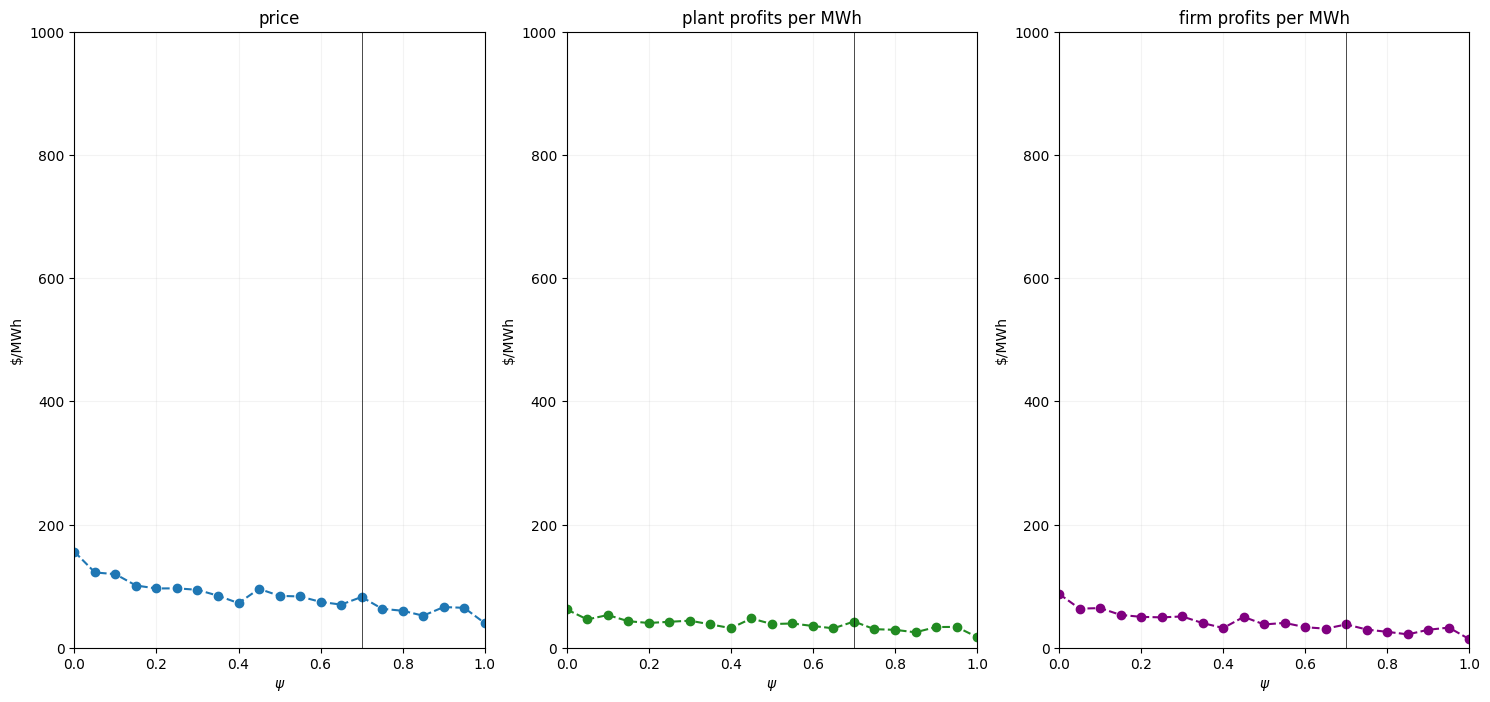

In [20]:
stationary_values = {}
number_of_plants = N
number_of_firms = M
prices = []
plant_profits = []
firm_profits = []
for psi in psis:
    stationary_values[psi] = {}
    csv_filenames = csv_filenames_dict[psi]
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    
    stationary_values[psi]['price'] = utils.get_stationary_value(np.array(prices_data_list))
    
    plants_info_df = pd.read_csv(database_path)
    plant_capacities = plants_info_df['capacity'].to_numpy()
    total_capacity_of_firms = np.zeros(number_of_firms)
    for firm in firm_portfolios_dict.keys():
        total_capacity_of_firms[firm] = structured_firm_dict[firm]['total_capacity']
    avg_plant_profit_through_time = np.zeros(t_max)
    avg_firm_profit_through_time = np.zeros(t_max)
    for t in range(t_max):
        plant_profits_at_time_t = np.zeros(number_of_plants)
        for plant in range(number_of_plants):
            plant_profits_at_time_t[plant] = plant_profits_data[plant][t]/plant_capacities[plant]
        avg_plant_profit_through_time[t] = np.mean(plant_profits_at_time_t)
        firm_profits_at_time_t = np.zeros(number_of_firms)
        for firm in range(number_of_firms):
            firm_profits_at_time_t[firm] = firm_profits_data[firm][t]/total_capacity_of_firms[firm]
        avg_firm_profit_through_time[t] = np.mean(firm_profits_at_time_t)
    stationary_values[psi]['plant_profits'] = utils.get_stationary_value(avg_plant_profit_through_time)
    stationary_values[psi]['firm_profits'] = utils.get_stationary_value(avg_firm_profit_through_time)

    prices.append(stationary_values[psi]['price'])
    plant_profits.append(stationary_values[psi]['plant_profits'])
    firm_profits.append(stationary_values[psi]['firm_profits'])
    
#plotting
colors = ['#1f77b4', 'forestgreen', 'purple']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))
### ax1: prices
ax1.plot(psis, prices, marker='o', linestyle='--', color = colors[0])
ax1.axvline(0.7, color='black', linewidth=.5)
ax1.set_xlim(0, 1)
ax1.set_ylim(min_price, max_price)
ax1.set_xlabel('$\psi$')
ax1.set_ylabel('$/MWh')
ax1.set_title(f"price")
ax1.grid(alpha=0.15)
### ax2: profits per plant
ax2.plot(psis, plant_profits, marker='o', linestyle='--', color = colors[1])
ax2.axvline(0.7, color='black', linewidth=.5)
ax2.set_xlim(0, 1)
ax2.set_ylim(min_price, max_price)
ax2.set_xlabel('$\psi$')
ax2.set_ylabel('$/MWh')
ax2.set_title(f"plant profits per MWh")
ax2.grid(alpha=0.15)
### ax2: profits per firm
ax3.plot(psis, firm_profits, marker='o', linestyle='--', color = colors[2])
ax3.axvline(0.7, color='black', linewidth=.5)
ax3.set_xlim(0, 1)
ax3.set_ylim(min_price, max_price)
ax3.set_xlabel('$\psi$')
ax3.set_ylabel('$/MWh')
ax3.set_title(f"firm profits per MWh")
ax3.grid(alpha=0.15)
plt.savefig(f'./Figures/Varying_Params/{param_to_vary}/overview.png')
plt.show()

### Varying $s1$

In [21]:
param_to_vary = 's1'
s1s = [1, 10, 100, 10000, 50000, 100000, 500000, 1000000, 1500000]
csv_filenames_dict = {}
run_counter = 0
for s1 in s1s:
    run_counter += 1
    print('-'*44)
    print(f'{run_counter} - s1: {s1}')
    epsilon = 0.89
    r = 0.07
    psi = 0.7
    #s1 = 700000

    ER_params = [epsilon, r, psi, s1]

    costs_management = 'both_costs'
    run_type = 'multiple'
    timestep_in_days = 1

    t_max = 600
    demand_type = 'constant'
    output_path = f'./Simulation_Results/'

    simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)
    print(f'Initialized simulation with params: {ER_params}')
    plot_saving_directory = fr'./Figures/Varying_Params/{param_to_vary}/eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}_t_max_{t_max}/'
    csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, total_capacity_fraction=None, output_path=output_path, run_ID=0)
    csv_filenames_dict[s1] = csv_filenames
    print('saving plots...')
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    chosen_action_data = utils.load_dict_data_from_csv(csv_filenames['chosen_action_data'], data_to_load='chosen_action_data')
    bid_data = utils.load_dict_data_from_csv(csv_filenames['bid_data'], data_to_load='bid_data')
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    save_path = os.path.join(plot_saving_directory, 'simulation_overview.png')
    myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management, should_save=True, save_path=save_path, should_show=False)
    save_path = os.path.join(plot_saving_directory, 'firm_profit.png')
    myplot.firm_profits(firm_profits_data, firm_portfolios_dict, structured_firm_dict, profits_per='MWh', t_max = t_max, ER_params=ER_params, should_save=True, save_path=save_path, should_show=False)

--------------------------------------------
1 - s1: 1
Initialized simulation with params: [0.89, 0.07, 0.7, 1]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
2 - s1: 10
Initialized simulation with params: [0.89, 0.07, 0.7, 10]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
3 - s1: 100
Initialized simulation with params: [0.89, 0.07, 0.7, 100]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
4 - s1: 10000
Initialized simulation with params: [0.89, 0.07, 0.7, 10000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
5 - s1: 50000
Initialized simulation with params: [0.89, 0.07, 0.7, 5

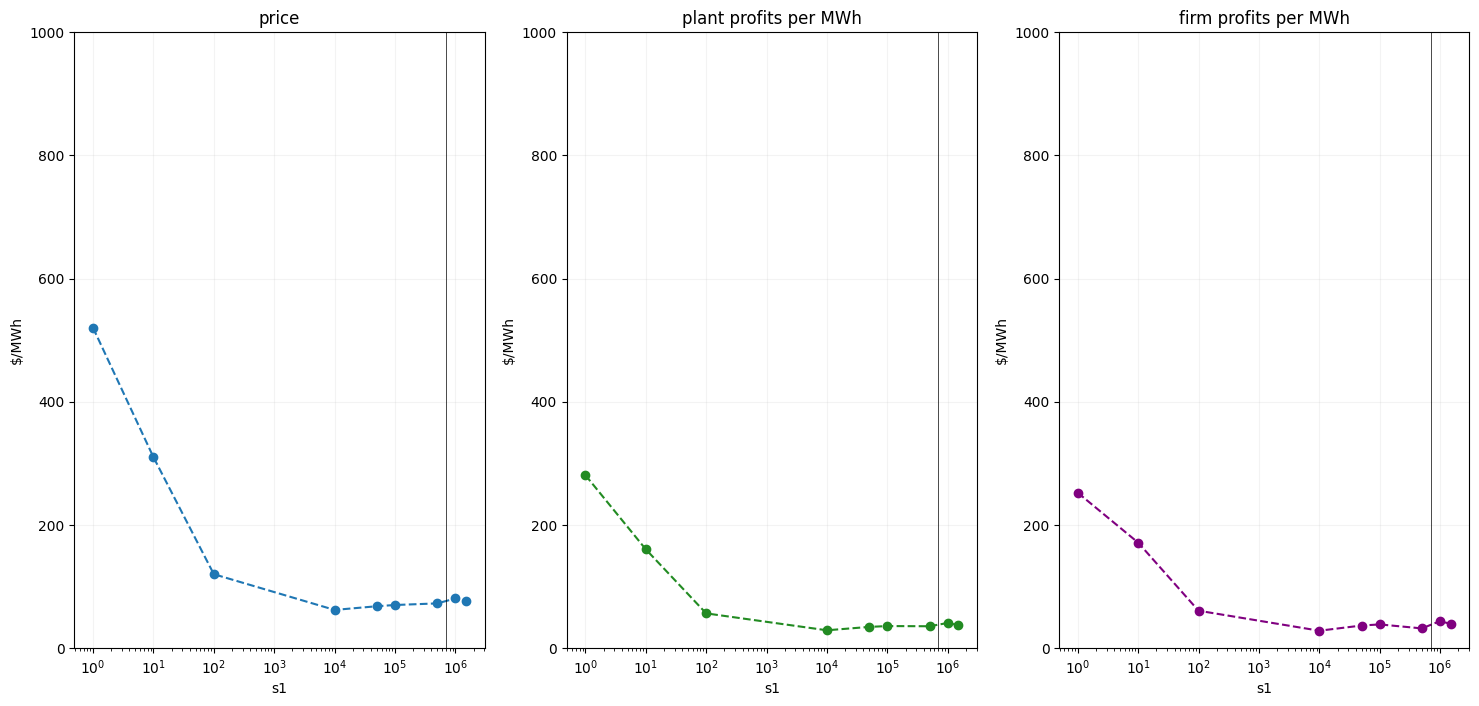

In [22]:
stationary_values = {}
number_of_plants = N
number_of_firms = M
prices = []
plant_profits = []
firm_profits = []
for s1 in s1s:
    stationary_values[s1] = {}

    csv_filenames = csv_filenames_dict[s1]
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    
    stationary_values[s1]['price'] = utils.get_stationary_value(np.array(prices_data_list))
    
    plants_info_df = pd.read_csv(database_path)
    plant_capacities = plants_info_df['capacity'].to_numpy()
    total_capacity_of_firms = np.zeros(number_of_firms)
    for firm in firm_portfolios_dict.keys():
        total_capacity_of_firms[firm] = structured_firm_dict[firm]['total_capacity']
    avg_plant_profit_through_time = np.zeros(t_max)
    avg_firm_profit_through_time = np.zeros(t_max)
    for t in range(t_max):
        plant_profits_at_time_t = np.zeros(number_of_plants)
        for plant in range(number_of_plants):
            plant_profits_at_time_t[plant] = plant_profits_data[plant][t]/plant_capacities[plant]
        avg_plant_profit_through_time[t] = np.mean(plant_profits_at_time_t)
        firm_profits_at_time_t = np.zeros(number_of_firms)
        for firm in range(number_of_firms):
            firm_profits_at_time_t[firm] = firm_profits_data[firm][t]/total_capacity_of_firms[firm]
        avg_firm_profit_through_time[t] = np.mean(firm_profits_at_time_t)
    stationary_values[s1]['plant_profits'] = utils.get_stationary_value(avg_plant_profit_through_time)
    stationary_values[s1]['firm_profits'] = utils.get_stationary_value(avg_firm_profit_through_time)

    prices.append(stationary_values[s1]['price'])
    plant_profits.append(stationary_values[s1]['plant_profits'])
    firm_profits.append(stationary_values[s1]['firm_profits'])
    
#plotting
colors = ['#1f77b4', 'forestgreen', 'purple']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))
### ax1: prices
ax1.plot(s1s, prices, marker='o', linestyle='--', color = colors[0])
ax1.axvline(700000, color='black', linewidth=.5)
#ax1.set_xlim(0, 1500000)
ax1.set_xscale('log')
ax1.set_ylim(min_price, max_price)
ax1.set_xlabel('s1')
ax1.set_ylabel('$/MWh')
ax1.set_title(f"price")
ax1.grid(alpha=0.15)
### ax2: profits per plant
ax2.plot(s1s, plant_profits, marker='o', linestyle='--', color = colors[1])
ax2.axvline(700000, color='black', linewidth=.5)
#ax2.set_xlim(0, 1500000)
ax2.set_xscale('log')
ax2.set_ylim(min_price, max_price)
ax2.set_xlabel('s1')
ax2.set_ylabel('$/MWh')
ax2.set_title(f"plant profits per MWh")
ax2.grid(alpha=0.15)
### ax2: profits per firm
ax3.plot(s1s, firm_profits, marker='o', linestyle='--', color = colors[2])
ax3.axvline(700000, color='black', linewidth=.5)
#ax3.set_xlim(0, 1500000)
ax3.set_xscale('log')
ax3.set_ylim(min_price, max_price)
ax3.set_xlabel('s1')
ax3.set_ylabel('$/MWh')
ax3.set_title(f"firm profits per MWh")
ax3.grid(alpha=0.15)
plt.savefig(f'./Figures/Varying_Params/{param_to_vary}/overview.png')
plt.show()

## Varying agents' domain

In [30]:
max_prices = np.arange(500,5250, 250)
csv_filenames_dict = {}
run_counter = 0
for max_price in max_prices:
    J = int((max_price-min_price)/(price_increment)+1) #total number of actions (prices)
    
    run_counter += 1
    print('-'*44)
    print(f'{run_counter} - max_price: {max_price}')
    epsilon = 0.89
    r = 0.07
    psi = 0.7
    s1 = 700000

    ER_params = [epsilon, r, psi, s1]

    costs_management = 'both_costs'
    run_type = 'multiple'
    timestep_in_days = 1

    t_max = 600
    demand_type = 'constant'
    output_path = f'./Simulation_Results/Varying_Action_Domain/Max_price_{max_price}/'

    simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)
    print(f'Initialized simulation with params: {ER_params}')
    plot_saving_directory = fr'./Figures/Varying_Action_Domain/eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}_t_max_{t_max}/Max_price_{max_price}/'
    csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, total_capacity_fraction=None, output_path=output_path, run_ID=0)
    csv_filenames_dict[max_price] = csv_filenames
    print('saving plots...')    
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    save_path = os.path.join(plot_saving_directory, 'simulation_overview.png')
    myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management, should_save=True, save_path=save_path, should_show=False)

--------------------------------------------
1 - max_price: 500
Initialized simulation with params: [0.89, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
2 - max_price: 750
Initialized simulation with params: [0.89, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
3 - max_price: 1000
Initialized simulation with params: [0.89, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
4 - max_price: 1250
Initialized simulation with params: [0.89, 0.07, 0.7, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
saving plots...
--------------------------------------------
5 - max_price: 1500
Initi

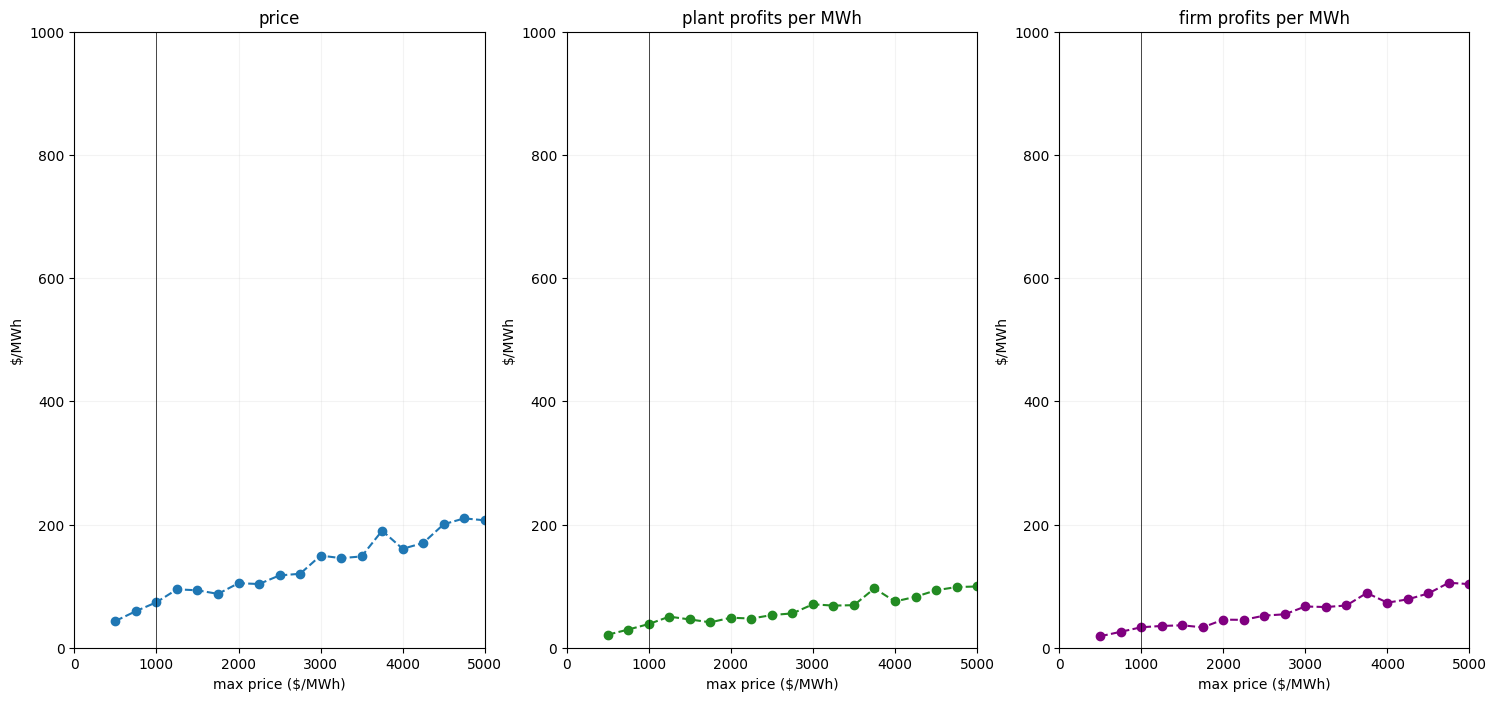

In [34]:
stationary_values = {}
number_of_plants = N
number_of_firms = M
prices = []
plant_profits = []
firm_profits = []
for max_price in max_prices:
    stationary_values[max_price] = {}

    csv_filenames = csv_filenames_dict[max_price]
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    
    stationary_values[max_price]['price'] = utils.get_stationary_value(np.array(prices_data_list))
    
    plants_info_df = pd.read_csv(database_path)
    plant_capacities = plants_info_df['capacity'].to_numpy()
    total_capacity_of_firms = np.zeros(number_of_firms)
    for firm in firm_portfolios_dict.keys():
        total_capacity_of_firms[firm] = structured_firm_dict[firm]['total_capacity']
    avg_plant_profit_through_time = np.zeros(t_max)
    avg_firm_profit_through_time = np.zeros(t_max)
    for t in range(t_max):
        plant_profits_at_time_t = np.zeros(number_of_plants)
        for plant in range(number_of_plants):
            plant_profits_at_time_t[plant] = plant_profits_data[plant][t]/plant_capacities[plant]
        avg_plant_profit_through_time[t] = np.mean(plant_profits_at_time_t)
        firm_profits_at_time_t = np.zeros(number_of_firms)
        for firm in range(number_of_firms):
            firm_profits_at_time_t[firm] = firm_profits_data[firm][t]/total_capacity_of_firms[firm]
        avg_firm_profit_through_time[t] = np.mean(firm_profits_at_time_t)
    stationary_values[max_price]['plant_profits'] = utils.get_stationary_value(avg_plant_profit_through_time)
    stationary_values[max_price]['firm_profits'] = utils.get_stationary_value(avg_firm_profit_through_time)

    prices.append(stationary_values[max_price]['price'])
    plant_profits.append(stationary_values[max_price]['plant_profits'])
    firm_profits.append(stationary_values[max_price]['firm_profits'])
    
#plotting
colors = ['#1f77b4', 'forestgreen', 'purple']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))
### ax1: prices
ax1.plot(max_prices, prices, marker='o', linestyle='--', color = colors[0])
ax1.axvline(1000, color='black', linewidth=.5)
ax1.set_xlim(min_price, max(max_prices))
ax1.set_ylim(min_price, 1000)
#ax1.set_ylim(min_price, max(max_prices))
ax1.set_xlabel('max price ($/MWh)')
ax1.set_ylabel('$/MWh')
ax1.set_title(f"price")
ax1.grid(alpha=0.15)
### ax2: profits per plant
ax2.plot(max_prices, plant_profits, marker='o', linestyle='--', color = colors[1])
ax2.axvline(1000, color='black', linewidth=.5)
ax2.set_xlim(min_price, max(max_prices))
ax2.set_ylim(min_price, 1000)
#ax2.set_ylim(min_price, max(max_prices))
ax2.set_xlabel('max price ($/MWh)')
ax2.set_ylabel('$/MWh')
ax2.set_title(f"plant profits per MWh")
ax2.grid(alpha=0.15)
### ax2: profits per firm
ax3.plot(max_prices, firm_profits, marker='o', linestyle='--', color = colors[2])
ax3.axvline(1000, color='black', linewidth=.5)
ax3.set_xlim(min_price, max(max_prices))
ax3.set_ylim(min_price, 1000)
#ax3.set_ylim(min_price, max(max_prices))
ax3.set_xlabel('max price ($/MWh)')
ax3.set_ylabel('$/MWh')
ax3.set_title(f"firm profits per MWh")
ax3.grid(alpha=0.15)

plt.savefig(f'./Figures/Varying_Action_Domain/eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}_t_max_{t_max}/overview.png')
plt.show()